### Here i will implement messages, chatLLms, Tools

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [3]:

from langchain_core.messages import AIMessage, HumanMessage
from pprint import pprint ### for printing in good way

messages=[AIMessage(content="hey hi how are you doing, how can i help you",name="LLM")]
messages.append(HumanMessage(content="what is the date and time now",name="user"))
messages.append(AIMessage(content="what is your location",name="LLM"))
messages.append(HumanMessage(content="iam in missouri, saint louis",name="user"))

messages

[AIMessage(content='hey hi how are you doing, how can i help you', additional_kwargs={}, response_metadata={}, name='LLM'),
 HumanMessage(content='what is the date and time now', additional_kwargs={}, response_metadata={}, name='user'),
 AIMessage(content='what is your location', additional_kwargs={}, response_metadata={}, name='LLM'),
 HumanMessage(content='iam in missouri, saint louis', additional_kwargs={}, response_metadata={}, name='user')]

In [4]:
for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLM

hey hi how are you doing, how can i help you
================================ Human Message =================================
Name: user

what is the date and time now
================================== Ai Message ==================================
Name: LLM

what is your location
================================ Human Message =================================
Name: user

iam in missouri, saint louis


###now with llm models

In [5]:
from langchain_openai import ChatOpenAI

llm=ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='I can\'t provide real-time information, including the current date and time, as I don\'t have access to live data. However, you can easily check the current date and time on your device or by doing a quick online search for "current time in St. Louis, Missouri."', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 57, 'total_tokens': 112, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a4d13246c5', 'id': 'chatcmpl-Cl5IjDqGMWkBfQYWtgo38n3HpedHQ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--a406e16e-ed15-45f0-8367-a891912a545b-0', usage_metadata={'input_tokens': 57, 'output_tokens': 55, 'total_tokens': 112, 'input_token_detail

### Tool Calling

In [6]:
llm

ChatOpenAI(profile={'max_input_tokens': 128000, 'max_output_tokens': 16384, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x000001E06886E6F0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001E06886F800>, root_client=<openai.OpenAI object at 0x000001E066CE7740>, root_async_client=<openai.AsyncOpenAI object at 0x000001E06836B4A0>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [7]:
def divide(a:int, b: int)->int:
    '''for message in messages["messages"]:
    message.pretty_print()'''
    return a/b


In [8]:
llm_tools=llm.bind_tools([divide])
tool_call=llm_tools.invoke("what is 10 divided by 5")
tool_call.tool_calls

[{'name': 'divide',
  'args': {'a': 10, 'b': 5},
  'id': 'call_O0Q7V1y9oMq9iVHX9aVGHyR4',
  'type': 'tool_call'}]

In [9]:
### using messages as states by implenting through reducer

from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from typing import Annotated

In [10]:
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]


In [11]:
prev_messages=[AIMessage(content="hey hi how are you doing, how can i help you",name="LLM")]
prev_messages.append(HumanMessage(content="what is the date and time now",name="user"))

ai_msg=AIMessage(content="what is your location",name="LLM")

In [12]:
add_messages(prev_messages,ai_msg)

[AIMessage(content='hey hi how are you doing, how can i help you', additional_kwargs={}, response_metadata={}, name='LLM', id='4989abce-d30d-40db-912a-d918a8d67c62'),
 HumanMessage(content='what is the date and time now', additional_kwargs={}, response_metadata={}, name='user', id='42da5797-75f3-4969-a027-416d5c7169b6'),
 AIMessage(content='what is your location', additional_kwargs={}, response_metadata={}, name='LLM', id='11454be5-e8cc-47ee-91df-340b3445b7db')]

In [13]:
def llm_with_tool(state:State):
    return {"messages":[llm_tools.invoke(state["messages"])]}

In [14]:
from IPython.display import Image, display
from langgraph.graph import StateGraph,START,END

builder=StateGraph(State)

builder.add_node("llm_with_tools_node",llm_with_tool)

builder.add_edge(START,"llm_with_tools_node")
builder.add_edge("llm_with_tools_node",END)
graph=builder.compile()

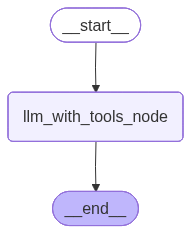

In [15]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
messages=graph.invoke({"messages":"what is 20 divided by 3"})
messages
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is 20 divided by 3
================================== Ai Message ==================================
Tool Calls:
  divide (call_Cfb7G9dmnD6wYB02HV0xiTCi)
 Call ID: call_Cfb7G9dmnD6wYB02HV0xiTCi
  Args:
    a: 20
    b: 3


### NOW to displat output we have to add tool node and connect to end

In [17]:
# so building the graph again rather than using the above
tools=[divide]
from langgraph.prebuilt import ToolNode , tools_condition

builder=StateGraph(State)


builder.add_node("llm_with_tools",llm_with_tool)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"llm_with_tools")
builder.add_conditional_edges("llm_with_tools",tools_condition)
builder.add_edge("tools",END)



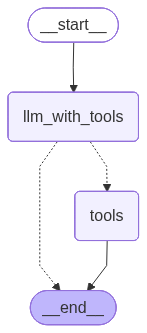

In [18]:
graph_builder=builder.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [19]:
messages=graph_builder.invoke({"messages":"what is 100 by 50"})
messages
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is 100 by 50
================================== Ai Message ==================================
Tool Calls:
  divide (call_VkM9McBuBYS2NBSxQKhE83hb)
 Call ID: call_VkM9McBuBYS2NBSxQKhE83hb
  Args:
    a: 100
    b: 50
================================= Tool Message =================================
Name: divide

2.0
